In [1]:
import xmitgcm
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
import scipy
from matplotlib import pyplot as plt 
import cartopy as cart
import pyresample
import pandas as pd
import nc_time_axis


from mpl_toolkits.mplot3d import Axes3D 
from scipy import interpolate
import scipy.io as sio

import warnings; warnings.simplefilter('ignore')

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, -54, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.SouthPolarStereo(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['j', 'i']), "da must have dimensions ['j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)
        field1 = pyresample.kd_tree.resample_nearest(self.orig_grid, coords.Depth.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)
        p1 = ax.contour(x[:,:split_lon_idx], y[:,:split_lon_idx], field1[:,:split_lon_idx],
                         [1000], colors='black',transform=cart.crs.PlateCarree(), zorder=1)
        p1 = ax.contour(x[:,split_lon_idx:], y[:,split_lon_idx:], field1[:,split_lon_idx:],
                         [1000], colors='black',transform=cart.crs.PlateCarree(), zorder=2)
        ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='black',linestyle=':')
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.4, label=label)
        return ax

In [2]:
from dask_jobqueue import SGECluster

cluster = SGECluster(cores=1,memory="6GB", interface="ib0",
             queue="Analysis3.q",
             walltime="08:00:00")

cluster.scale(10)
  
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.2.1.7:36598,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
cluster

Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.2.1.7:36598,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
cluster.close()

In [4]:
datadir1 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4pI_cycle3/results/diags/'  
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4pI_cycle3/results/'  
ds = xmitgcm.open_mdsdataset(datadir1,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2',
                                                               'fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 1200,ref_date='0001-01-01')
#ds = ds.assign_coords(time=(ds.time+np.datetime64("1992-12-31")))
coords = ds.coords.to_dataset().reset_coords()
#ds = ds.reset_coords(drop=True)
mapper = LLCMapper(coords)
#mapper(coords.Depth);
datadir = '/data3/astewart/MITgcm_SO/experiments_mky/llc270_notides_ref/results/'  
#icedraft = xmitgcm.utils.read_raw_data(datadir+'draft_llc270_rtopo_1080x310.bin', np.dtype('>f4'), (310, 1080))
#coords['icedraft']=(("j", "i"),icedraft)
ds['mask'] = xr.where((ds.SHIfwFlx[0]!=0)& (ds.THETA[0]!=0),1,0).transpose('k','j','i')

#ds.l1_c.attrs['axis'] = '1RHO'
#ds.l1_i.attrs['axis'] = '1RHO'
#ds.l1_b.attrs['axis'] = '1RHO'
#ds.l1_i.attrs['c_grid_axis_shift'] = 0.5
#ds.l1_b.attrs['c_grid_axis_shift'] = 0.5
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(ds,periodic=False,metrics=metrics)#,coords={'1RHO':{'center':'l1_c','inner':'l1_i','outer':'l1_b'}})
grid
ds

datadir2 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP_fixstrat/results/diags/' 
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP_fixstrat/results/' 
ds1 = xmitgcm.open_mdsdataset(datadir2,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2',
                                                                'fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 900,ref_date='0001-01-01')
#ds1 = ds1.assign_coords(time=(ds1.time+np.datetime64("1992-12-31")))
#grid = xgcm.Grid(ds1, periodic=False)
#coords = ds1.coords.to_dataset().reset_coords()
#ds1 = ds1.reset_coords(drop=True)

ds1

datadir3 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP/results/diags/' 
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP/results/'    
ds2 = xmitgcm.open_mdsdataset(datadir3,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2',
                                                                'fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 900,ref_date='0001-01-01')
#ds2 = ds2.assign_coords(time=(ds2.time+np.datetime64("1992-12-31")))
#grid = xgcm.Grid(ds1, periodic=False)
#coords = ds1.coords.to_dataset().reset_coords()
#ds1 = ds1.reset_coords(drop=True)

ds2

<xarray.Dataset>
Dimensions:   (i: 1080, i_g: 1080, j: 310, j_g: 310, k: 113, k_u: 113,
               k_l: 113, k_p1: 114, time: 227, _UNKNOWN_: 123)
Coordinates: (12/49)
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * k         (k) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
    ...        ...
    rSurfC    (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rSurfS    (j_g, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rSurfW    (j, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rhoRef    (k) >f4 dask.array<chunksize=(113,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) object 0001-01-24 06:00:00 ... 0015-03-07 00:00:00
Dimensions without coordinates: _UNKNOWN_
Data variables: (12/68)
    UVELTH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    VVELTH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    WVELTH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    UVELSLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    VVELSLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    WVELSLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    ...        ...
    SIqneti   (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIempmr   (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIsnPrcp  (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIacSubl  (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    botTauX   (time, j, i_g) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    botTauY   (time, j_g, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/data2/antarc...

In [6]:
coords

<xarray.Dataset>
Dimensions:  (i: 1080, i_g: 1080, j: 310, j_g: 310, k: 113, k_u: 113, k_l: 113,
              k_p1: 114, time: 227)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * k        (k) int64 0 1 2 3 4 5 6 7 8 ... 104 105 106 107 108 109 110 111 112
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 ... 106 107 108 109 110 111 112 113
  * time     (time) object 0001-02-01 00:00:00 ... 0019-11-27 00:00:00
Data variables: (12/40)
    XC       (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    YC       (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    XG       (j_g, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    YG       (j_g, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    CS       (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    SN       (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    ...       ...
    rLowS    (j_g, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rLowW    (j, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rhoRef   (k) >f4 dask.array<chunksize=(113,), meta=np.ndarray>
    rSurfC   (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rSurfW   (j, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/data2/antarc...

In [5]:
cp = 3.994e3 # J/kg/K
rho0 = 1.029e3 # kg/m^3
Lf = 3.33e5 # J/kg
gtfactor = 1e-12 # Gt/kg
secfactor = 3.154e7 # s/yr

conversion = cp*rho0/Lf*gtfactor*secfactor

In [6]:
# depth integrate U, V heat fluxes
icemask= ds.mask.any(axis=0)
intu = grid.integrate((ds.UVELTH),axis='Z')
intv = grid.integrate((ds.VVELTH),axis='Z')

# take horizontal divergence d/dx U flux + d/dy V flux
divflux = grid.derivative(intu,axis='X') + grid.derivative(intv,axis='Y').compute()

# integrate over whole cavity (maybe the trickiest step)
totalflux = -1*grid.integrate(divflux*icemask,axis=['X','Y'])

# depth integrate U, V heat fluxes
intu1 = grid.integrate((ds1.UVELTH),axis='Z')
intv1 = grid.integrate((ds1.VVELTH),axis='Z')

# take horizontal divergence d/dx U flux + d/dy V flux
divflux1 = grid.derivative(intu1,axis='X') + grid.derivative(intv1,axis='Y').compute()

# integrate over whole cavity (maybe the trickiest step)
totalflux1 = -1*grid.integrate(divflux1*icemask,axis=['X','Y'])

# depth integrate U, V heat fluxes
intu2 = grid.integrate((ds2.UVELTH),axis='Z')
intv2 = grid.integrate((ds2.VVELTH),axis='Z')

# take horizontal divergence d/dx U flux + d/dy V flux
divflux2 = (grid.derivative(intu2,axis='X') + grid.derivative(intv2,axis='Y')).compute()

# integrate over whole cavity (maybe the trickiest step)
totalflux2 = -1*grid.integrate(divflux2*icemask,axis=['X','Y'])

In [9]:
amerypI = divflux.where((((coords.XC<=84) & (coords.XC>67))))
amerypIcalc = -1*conversion*(grid.integrate((amerypI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
print(amerypIcalc)

<xarray.DataArray ()>
array(367.78121036)


In [7]:
totalforced = ((totalflux1-totalflux)*conversion)[-120:].mean(dim='time').compute()
totalmelt = ((totalflux2-totalflux1)*conversion)[-120:].mean(dim='time').compute()
totaldiff = ((totalflux2-totalflux)*conversion)[-120:].mean(dim='time').compute()

# Ross
rosspI = divflux.where(((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))
rosspIcalc = -1*conversion*(grid.integrate((rosspI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
rossfix = divflux1.where(((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))
rossSSP = divflux2.where(((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))

rossforced = conversion*(grid.integrate((rosspI-rossfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
rossmelt =  conversion*(grid.integrate((rossfix-rossSSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
rossdiff = -1*conversion*(grid.integrate((rossSSP-rosspI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

rossFerr = conversion*(grid.integrate((rosspI-rossfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
rossMerr =  conversion*(grid.integrate((rossfix-rossSSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
rosserr = -1*conversion*(grid.integrate((rossSSP-rosspI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Adelie (coords.XC > 140)&(coords.YC>-72)
adeliepI = divflux.where((coords.XC > 140)&(coords.YC>-72))
adeliepIcalc = -1*conversion*(grid.integrate((adeliepI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
adeliefix = divflux1.where((coords.XC > 140)&(coords.YC>-72))
adelieSSP = divflux2.where((coords.XC > 140)&(coords.YC>-72))

adelieforced = conversion*(grid.integrate((adeliepI-adeliefix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
adeliemelt =  conversion*(grid.integrate((adeliefix-adelieSSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
adeliediff = -1*conversion*(grid.integrate((adelieSSP-adeliepI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

adelieFerr = conversion*(grid.integrate((adeliepI-adeliefix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
adelieMerr =  conversion*(grid.integrate((adeliefix-adelieSSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
adelieerr = -1*conversion*(grid.integrate((adelieSSP-adeliepI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Weddell
weddellpI = divflux.where(((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74)))
weddellpIcalc = -1*conversion*(grid.integrate((weddellpI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
weddellfix = divflux1.where(((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74)))
weddellSSP = divflux2.where(((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74)))

weddellforced = conversion*(grid.integrate((weddellpI-weddellfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
weddellmelt =  conversion*(grid.integrate((weddellfix-weddellSSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
weddelldiff = -1*conversion*(grid.integrate((weddellSSP-weddellpI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

weddellFerr = conversion*(grid.integrate((weddellpI-weddellfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
weddellMerr =  conversion*(grid.integrate((weddellfix-weddellSSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
weddellerr = conversion*(grid.integrate((weddellSSP-weddellpI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Antarctic peninsula
appI = divflux.where((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))
appIcalc = -1*conversion*(grid.integrate((appI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
apfix = divflux1.where((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))
apSSP = divflux2.where((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))

apforced = conversion*(grid.integrate((appI-apfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
apmelt =  conversion*(grid.integrate((apfix-apSSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
apdiff = -1*conversion*(grid.integrate((apSSP-appI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

apFerr = conversion*(grid.integrate((appI-apfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
apMerr =  conversion*(grid.integrate((apfix-apSSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
aperr = -1*conversion*(grid.integrate((apSSP-appI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Amundsen
amundsenpI = divflux.where((-145<coords.XC) & (coords.XC<=-98))
amundsenpIcalc = -1*conversion*(grid.integrate((amundsenpI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
amundsenfix = divflux1.where((-145<coords.XC) & (coords.XC<=-98))
amundsenSSP = divflux2.where((-145<coords.XC) & (coords.XC<=-98))

amundsenforced = conversion*(grid.integrate((amundsenpI-amundsenfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
amundsenmelt =  conversion*(grid.integrate((amundsenfix-amundsenSSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
amundsendiff = -1*conversion*(grid.integrate((amundsenSSP-amundsenpI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

amundsenFerr = conversion*(grid.integrate((amundsenpI-amundsenfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
amundsenMerr =  conversion*(grid.integrate((amundsenfix-amundsenSSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
amundsenerr = -1*conversion*(grid.integrate((amundsenSSP-amundsenpI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Bellingshausen
bellpI = divflux.where(((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)))
bellfix = divflux1.where(((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)))
bellSSP = divflux2.where(((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)))
bellpIcalc = -1*conversion*(grid.integrate((bellpI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

bellforced = conversion*(grid.integrate((bellpI-bellfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
bellmelt =  conversion*(grid.integrate((bellfix-bellSSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
belldiff = -1*conversion*(grid.integrate((bellSSP-bellpI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

bellFerr = conversion*(grid.integrate((bellpI-bellfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
bellMerr =  conversion*(grid.integrate((bellfix-bellSSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
bellerr = -1*conversion*(grid.integrate((bellSSP-bellpI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# EA W - Maud
eapIW = divflux.where((0<coords.XC) & (coords.XC<=40))
eafixW = divflux1.where(((0<coords.XC) & (coords.XC<=40)))
eaSSPW = divflux2.where(((0<coords.XC) & (coords.XC<=40)))
eapIWcalc = -1*conversion*(grid.integrate((eapIW-eafixW)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

eaforcedW = conversion*(grid.integrate((eapIW-eafixW)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
eameltW =  conversion*(grid.integrate((eafixW-eaSSPW)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
eadiffW = -1*conversion*(grid.integrate((eaSSPW-eapIW)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

eaFerrW = conversion*(grid.integrate((eapIW-eafixW)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
eaMerrW =  conversion*(grid.integrate((eafixW-eaSSPW)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
eaerrW = -1*conversion*(grid.integrate((eaSSPW-eapIW)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# EA E - Wilkes
eapIE = divflux.where((coords.XC>84) & (coords.XC<=140))
eafixE = divflux1.where((coords.XC>84) & (coords.XC<=140))
eaSSPE = divflux2.where((coords.XC>84) & (coords.XC<=140))
eapIEcalc = -1*conversion*(grid.integrate((eapIE)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

eaforcedE = conversion*(grid.integrate((eapIE-eafixE)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
eameltE =  conversion*(grid.integrate((eafixE-eaSSPE)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
eadiffE = -1*conversion*(grid.integrate((eaSSPE-eapIE)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

eaFerrE = conversion*(grid.integrate((eapIE-eafixE)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
eaMerrE =  conversion*(grid.integrate((eafixE-eaSSPE)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
eaerrE = -1*conversion*(grid.integrate((eaSSPE-eapIE)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Amery
amerypI = divflux.where((((coords.XC<=84) & (coords.XC>67))))
ameryfix = divflux1.where((((coords.XC<=84) & (coords.XC>67))))
amerySSP = divflux2.where((((coords.XC<=84) & (coords.XC>67))))
amerypIcalc = -1*conversion*(grid.integrate((amerypI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

ameryforced = conversion*(grid.integrate((amerypI-ameryfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
amerymelt =  conversion*(grid.integrate((ameryfix-amerySSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
amerydiff = -1*conversion*(grid.integrate((amerySSP-amerypI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

ameryFerr = conversion*(grid.integrate((amerypI-ameryfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
ameryMerr =  conversion*(grid.integrate((ameryfix-amerySSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
ameryerr = -1*conversion*(grid.integrate((amerySSP-amerypI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

# Enderby (40<coords.XC) & (coords.XC<=67)
enderbypI = divflux.where((40<coords.XC) & (coords.XC<=67))
enderbyfix = divflux1.where((40<coords.XC) & (coords.XC<=67))
enderbySSP = divflux2.where((40<coords.XC) & (coords.XC<=67))
enderbypIcalc = -1*conversion*(grid.integrate((enderbypI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

enderbyforced = conversion*(grid.integrate((enderbypI-enderbyfix)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
enderbymelt =  conversion*(grid.integrate((enderbyfix-enderbySSP)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()
enderbydiff = -1*conversion*(grid.integrate((enderbySSP-enderbypI)*icemask,axis=['X','Y']))[-120:].mean(dim='time').compute()

enderbyFerr = conversion*(grid.integrate((enderbypI-enderbyfix)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
enderbyMerr =  conversion*(grid.integrate((enderbyfix-enderbySSP)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()
enderbyerr = -1*conversion*(grid.integrate((enderbySSP-enderbypI)*icemask,axis=['X','Y']))[-120:].std(dim='time',ddof=1).compute()

In [7]:
## plot total melt
meltmean = ((-ds2.SHIfwFlx[-120:]+ds.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')


## same calc for ross
rosspI = ds.where((coords.XC<=-145)|(coords.XC > 160)).where(coords.YC<=-75)
rossSSP = ds2.where((coords.XC<=-145)|(coords.XC > 160)).where(coords.YC<=-75)# or coords.XC<=-145 & coords.YC<=-75
rossmean = ((-rossSSP.SHIfwFlx[-120:]+rosspI.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')

weddellpI = ds.where((-85<coords.XC) & (coords.XC<=-30) & (coords.YC<=-74))
weddellSSP = ds2.where((-85<coords.XC) & (coords.XC<=-30) & (coords.YC<=-74))
weddellmean = ((-weddellSSP.SHIfwFlx[-120:]+weddellpI.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')


appI = ds.where((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-75))
apSSP = ds2.where((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-75))
apmean = ((-apSSP.SHIfwFlx[-120:]+appI.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')


amundsenpI = ds.where(((-145<coords.XC) & (coords.XC<=-103)) | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<-72)))
amundsenSSP = ds2.where(((-145<coords.XC) & (coords.XC<=-103)) | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<-72)))
amundsenmean = ((-amundsenSSP.SHIfwFlx[-120:]+amundsenpI.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')




bellpI = ds.where(((-103<coords.XC)&(coords.XC<-65)&(coords.YC>-74)) | 
                ((-100<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)) | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC>=-72)))
bellSSP = ds2.where(((-103<coords.XC)&(coords.XC<-65)&(coords.YC>-74)) | 
                ((-100<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)) | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC>=-72)))
bellmean = ((-bellSSP.SHIfwFlx[-120:]+bellpI.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')

eapIW = ds.where(((-30<coords.XC) & (coords.XC<=67)))
eaSSPW = ds2.where(((-30<coords.XC) & (coords.XC<=67)))
eameanW = ((-eaSSPW.SHIfwFlx[-120:]+eapIW.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')

eapIE = ds.where(((coords.XC>84) & (coords.XC<=160)) | ((coords.XC>160)&(coords.YC>-75)))
eaSSPE = ds2.where(((coords.XC>84) & (coords.XC<=160)) | ((coords.XC>160)&(coords.YC>-75)))
eameanE = ((-eaSSPE.SHIfwFlx[-120:]+eapIE.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')

amerypI = ds.where((((coords.XC<=84) & (coords.XC>67))))
amerySSP = ds2.where((((coords.XC<=84) & (coords.XC>67))))
amerymean = ((-amerySSP.SHIfwFlx[-120:]+amerypI.SHIfwFlx[-120:])*coords.rA/1e12*3.154e7).sum(dim=['j','i']).mean(dim='time')

In [8]:
sqrtn = np.sqrt(120)
species = ( "Weddell", "Antarctic \nPeninsula","Bellings-\nhausen","Amundsen","Ross","Adelie",
           "Wilkes","Amery","Enderby","Maud")
penguin_means = {
    'Total Melt Change': ( [weddelldiff,weddellerr/sqrtn], [apdiff, aperr/sqrtn] , [belldiff, bellerr/sqrtn],
                          [amundsendiff, amundsenerr/sqrtn], [rossdiff, rosserr/sqrtn],  [adeliediff, adelieerr/sqrtn], 
                          [eadiffE, eaerrE/sqrtn], [amerydiff,ameryerr/sqrtn],[enderbydiff, enderbyerr/sqrtn],
                          [eadiffW, eaerrW/sqrtn]) ,
    'Forced Response': ( [weddellforced, weddellFerr/sqrtn] ,[apforced, apFerr/sqrtn], [bellforced, bellFerr/sqrtn], 
                        [amundsenforced, amundsenFerr/sqrtn], [rossforced, rossFerr/sqrtn], [adelieforced, adelieFerr/sqrtn],
                        [eaforcedE, eaFerrE/sqrtn],[ameryforced, ameryFerr/sqrtn], [enderbyforced, enderbyFerr/sqrtn], 
                        [eaforcedW, eaFerrW/sqrtn]),
    'Melt Feedback': ( [weddellmelt, weddellMerr/sqrtn] ,[apmelt, apMerr/sqrtn],  [bellmelt,bellMerr/sqrtn],
                        [amundsenmelt, amundsenMerr/sqrtn],[rossmelt,rossMerr/sqrtn], [adeliemelt,adelieMerr/sqrtn], 
                      [eameltE,eaMerrE/sqrtn],[amerymelt, ameryMerr/sqrtn], [enderbymelt, enderbyMerr/sqrtn], 
                      [eameltW,eaMerrW/sqrtn]) , #: ( weddellMerr, apMerr, bellMerr, amundsenMerr, rossMerr, eaMerrE, 
                        #  eaMerrW,ameryMerr),
}


for attribute, measurement in penguin_means.items():
    print(np.array(measurement))
    print('next')
    
np.shape(measurement)

[[ 6.09210783e+02  1.83693069e+01]
 [-4.08121301e+01 -3.00206518e+00]
 [-3.32832628e+01 -1.32078090e+00]
 [ 3.32137919e+01 -2.32460276e+00]
 [-6.20766555e+01 -4.83173822e+00]
 [-4.26707206e+01 -2.61583149e+00]
 [-2.78687062e+01 -2.81481028e+00]
 [ 2.08287721e+01 -5.03939076e+00]
 [ 2.30961279e-01 -4.43419782e-02]
 [ 1.07031569e+02 -6.92814019e+00]]
next
[[  12.8783458    16.67346703]
 [   1.96892337    1.94508314]
 [ -14.92790227    1.91681184]
 [ -40.03790515    5.62525703]
 [  18.89348347    3.68737642]
 [  -6.09623738    2.61180193]
 [ -74.32124941    6.40109964]
 [-168.37868826    4.97790607]
 [   3.40771279    0.57083388]
 [-287.17768988   25.4844807 ]]
next
[[ 5.96332472e+02  1.63322825e+01]
 [-4.27810548e+01  1.96081632e+00]
 [-1.83553590e+01  1.25145974e+00]
 [ 7.32516940e+01  5.17166962e+00]
 [-8.09701435e+01  4.54665988e+00]
 [-3.65744767e+01  1.83601220e+00]
 [ 4.64525493e+01  4.97636921e+00]
 [ 1.89207460e+02  4.00591161e+00]
 [-3.17675120e+00  5.38419858e-01]
 [ 3.94209234

(10, 2)

In [47]:
sqrtn = np.sqrt(120)
species = ( "Weddell", "Antarctic \nPeninsula","Bellings-\nhausen","Amundsen","Ross","Adelie",
           "Wilkes","Amery","Enderby","Maud")
penguin_means = {
    'Total Melt Change': ( [weddelldiff/weddellpIcalc,weddellerr/sqrtn/weddellpIcalc],
                          [apdiff/appIcalc, aperr/sqrtn/appIcalc] , [belldiff/bellpIcalc, bellerr/sqrtn/bellpIcalc],
                      [amundsendiff/amundsenpIcalc, amundsenerr/sqrtn/amundsenpIcalc],[rossdiff/rosspIcalc, rosserr/sqrtn/rosspIcalc],
                          [adeliediff/adeliepIcalc, adelieerr/sqrtn/adeliepIcalc], 
                          [eadiffE/eapIEcalc, eaerrE/sqrtn/eapIEcalc], [amerydiff/amerypIcalc,ameryerr/sqrtn/amerypIcalc],
                            [enderbydiff/enderbypIcalc,enderbyerr/sqrtn/enderbypIcalc],[eadiffW/eapIWcalc, eaerrW/sqrtn/eapIWcalc]  ) ,
    'Forced Response': ( [weddellforced/weddellpIcalc, weddellFerr/sqrtn/weddellpIcalc] ,
                        [apforced/appIcalc, apFerr/sqrtn/appIcalc], [bellforced/bellpIcalc, bellFerr/sqrtn/bellpIcalc], 
               [amundsenforced/amundsenpIcalc, amundsenFerr/sqrtn/amundsenpIcalc], [rossforced/rosspIcalc, rossFerr/sqrtn/rosspIcalc], 
                        [adelieforced/adeliepIcalc, adelieFerr/sqrtn/adeliepIcalc],
                        [eaforcedE/eapIEcalc, eaFerrE/sqrtn/eapIEcalc],[ameryforced/amerypIcalc, ameryFerr/sqrtn/amerypIcalc],
                       [enderbyforced/enderbypIcalc, enderbyFerr/sqrtn/enderbypIcalc],[eaforcedW/eapIWcalc, eaFerrW/sqrtn/eapIWcalc]),
    'Melt Feedback': ( [weddellmelt/weddellpIcalc, weddellMerr/sqrtn/weddellpIcalc] ,
                      [apmelt/appIcalc, apMerr/sqrtn/appIcalc],  [bellmelt/bellpIcalc,bellMerr/sqrtn/bellpIcalc],
                [amundsenmelt/amundsenpIcalc, amundsenMerr/sqrtn/amundsenpIcalc],[rossmelt/rosspIcalc,rossMerr/sqrtn/rosspIcalc], 
                     [adeliemelt/adeliepIcalc, adelieMerr/sqrtn/adeliepIcalc],
                      [eameltE/eapIEcalc,eaMerrE/sqrtn/eapIEcalc],[amerymelt/amerypIcalc, ameryMerr/sqrtn/amerypIcalc],
                      [enderbymelt/enderbypIcalc, enderbyMerr/sqrtn/enderbypIcalc],[eameltW/eapIWcalc,eaMerrW/sqrtn/eapIWcalc]) , #: 
    #( weddellMerr, apMerr, 
    #bellMerr, amundsenMerr, rossMerr, eaMerrE, 
                        #  eaMerrW,ameryMerr),
}


for attribute, measurement in penguin_means.items():
    print(np.array(measurement))
    print('next')
    
np.shape(measurement)

[[ 4.88205217  0.14720671]
 [-1.80675044 -0.13290124]
 [-0.29323564 -0.01163648]
 [ 0.12743714 -0.00891921]
 [-0.41552795 -0.03234263]
 [-0.65635667 -0.04023645]
 [-0.18635673 -0.0188225 ]
 [ 0.05663359 -0.01370214]
 [ 3.27795328 -0.62933031]
 [ 0.37270154 -0.02412492]]
next
[[ 1.03203617e-01  1.33616703e-01]
 [ 8.71641140e-02  8.61087088e-02]
 [-1.31519346e-01  1.68876936e-02]
 [-1.53620403e-01  2.15834033e-02]
 [ 1.26468965e-01  2.46825145e-02]
 [-9.37717020e-02  4.01744710e-02]
 [-4.96982710e-01  4.28038532e-02]
 [-4.57822976e-01  1.35349657e-02]
 [ 4.83644850e+01  8.10164722e+00]
 [-1.00000000e+00  8.87411578e-02]]
next
[[ 4.77884884e+00  1.30882541e-01]
 [-1.89391461e+00  8.68052156e-02]
 [-1.61716280e-01  1.10257399e-02]
 [ 2.81057531e-01  1.98430455e-02]
 [-5.41996941e-01  3.04343754e-02]
 [-5.62584873e-01  2.82413525e-02]
 [ 3.10626019e-01  3.32767476e-02]
 [ 5.14456571e-01  1.08921051e-02]
 [-4.50865274e+01  7.64160619e+00]
 [ 1.37270146e+00  7.82018514e-02]]
next


(10, 2)

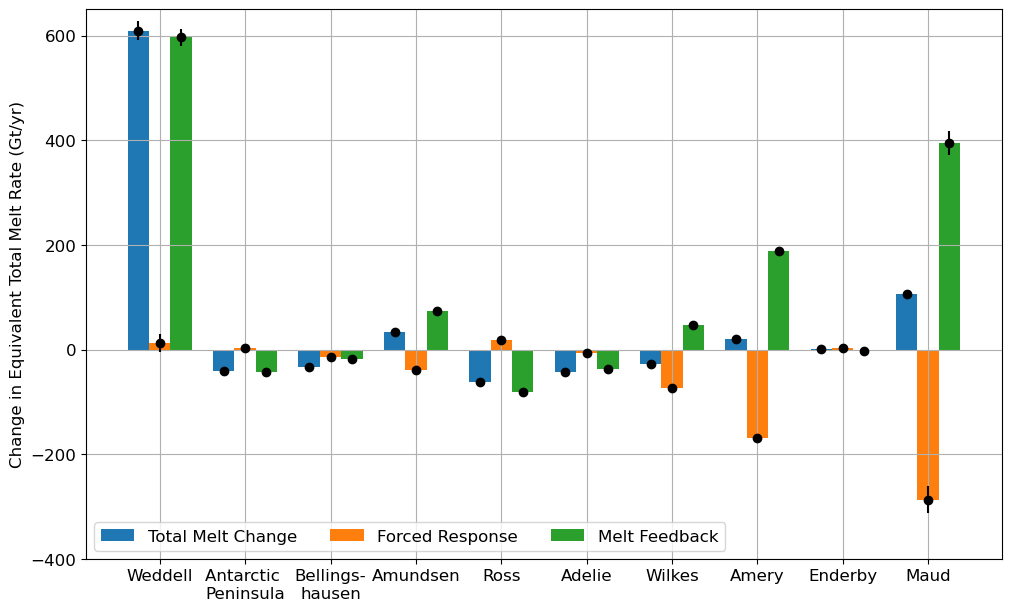

In [16]:
x = np.arange(len(species))  # the label locations\
width = 0.25  # the width of the bars
multiplier = 0
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(layout='constrained',figsize=(10,6))


for attribute, measurement in penguin_means.items():
    measurement = np.array(measurement)
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[:,0], width, label=attribute)
    ax.errorbar(x + offset, measurement[:,0], yerr=np.abs(measurement[:,1]), fmt="o", color="k")
#    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Change in Equivalent Total Melt Rate (Gt/yr)')
#ax.set_ylabel('Percent Change in Equivalent Melt Rate')
ax.set_title('')
ax.grid()
ax.set_xticks(x + width, species)
ax.legend(loc='lower left', ncols=3)
ax.set_ylim(-400, 650)


plt.show()

In [42]:
adeliediff

<xarray.DataArray ()>
array(-0.)

# Calculate the volume weighted temperature

In [6]:
###### preindustrial #############
rosspI = ds.where((((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))&(coords.Depth<800))
adeliepI =  ds.where((((coords.XC > 140))&(coords.YC>-72))&(coords.Depth<800))

weddellpI = ds.where((((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74))) &(coords.Depth<800))

amundsenpI = ds.where((((-145<coords.XC) & (coords.XC<=-98)) 
                     # | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<-72))
                      )&(coords.Depth<800))
bellpI = ds.where((((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)) 
                 )&(coords.Depth<800))

amerypI = ds.where(((coords.XC<=84) & (coords.XC>67))&(coords.Depth<800))

enderbypI = ds.where(((40<coords.XC) & (coords.XC<=67) & (coords.Depth<800)))

eapIW = ds.where(((0<coords.XC) & (coords.XC<=40) & (coords.Depth<800)))


eapIE = ds.where(((coords.XC>84) & (coords.XC<=140)) & (coords.Depth<800))

appI = ds.where(((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))&(coords.Depth<800))

##### fix ###################
rossfix = ds1.where((((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))&(coords.Depth<800))
adeliefix =  ds1.where((((coords.XC > 140))&(coords.YC>-72))&(coords.Depth<800))

weddellfix = ds1.where((((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74))) &(coords.Depth<800))

amundsenfix = ds1.where((((-145<coords.XC) & (coords.XC<=-98)) 
                     # | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<-72))
                      )&(coords.Depth<800))
bellfix = ds1.where((((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)) 
                 )&(coords.Depth<800))

ameryfix = ds1.where(((coords.XC<=84) & (coords.XC>67))&(coords.Depth<800))

enderbyfix = ds1.where(((40<coords.XC) & (coords.XC<=67) & (coords.Depth<800)))

eafixW = ds1.where(((0<coords.XC) & (coords.XC<=40) & (coords.Depth<800)))


eafixE = ds1.where(((coords.XC>84) & (coords.XC<=140)) & (coords.Depth<800))

apfix = ds1.where(((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))&(coords.Depth<800))


##### SSP #######################
rossSSP = ds2.where((((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))&(coords.Depth<800))
adelieSSP =  ds2.where((((coords.XC > 140))&(coords.YC>-72))&(coords.Depth<800))

weddellSSP = ds2.where((((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74))) &(coords.Depth<800))

amundsenSSP = ds2.where((((-145<coords.XC) & (coords.XC<=-98)) 
                     # | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<-72))
                      )&(coords.Depth<800))
bellSSP = ds2.where((((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)) 
                 )&(coords.Depth<800))

amerySSP = ds2.where(((coords.XC<=84) & (coords.XC>67))&(coords.Depth<800))

enderbySSP = ds2.where(((40<coords.XC) & (coords.XC<=67) & (coords.Depth<800)))

eaSSPW = ds2.where(((0<coords.XC) & (coords.XC<=40) & (coords.Depth<800)))


eaSSPE = ds2.where(((coords.XC>84) & (coords.XC<=140)) & (coords.Depth<800))

apSSP = ds2.where(((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))&(coords.Depth<800))

In [7]:
def VolWeightInt(da):
    integrated_value = grid.integrate(da[-120:].mean(dim='time'), axis = ['X','Y','Z'])
    integrated_volume = grid.integrate(da[0]*0+1, axis = ['X','Y','Z'])
    return integrated_value/integrated_volume
    
PIseas = [weddellpI,appI,amundsenpI, bellpI,rosspI,adeliepI, eapIE, amerypI,enderbypI,eapIW] 
Fixseas = [weddellfix,apfix,amundsenfix, bellfix,rossfix,adeliefix, eafixE, ameryfix,enderbyfix,eafixW] 
SSPseas = [weddellSSP,apSSP,amundsenSSP, bellSSP,rossSSP,adelieSSP, eaSSPE, amerySSP,enderbySSP,eaSSPW] 

PITemp =[]
PISal = []

for sea in PIseas:
    PITemp.append(VolWeightInt(sea.THETA).values)
    PISal.append(VolWeightInt(sea.SALT).values)
    
FixTemp =[]
FixSal = []
for sea in Fixseas:
    FixTemp.append(VolWeightInt(sea.THETA).values)
    FixSal.append(VolWeightInt(sea.SALT).values)
    
SSPTemp =[]
SSPSal = []
for sea in SSPseas:
    SSPTemp.append(VolWeightInt(sea.THETA).values)
    SSPSal.append(VolWeightInt(sea.SALT).values)
    
    

In [8]:
sqrtn = np.sqrt(120)
species = ( "Weddell", "Antarctic \nPeninsula","Bellings-\nhausen","Amundsen","Ross","Adelie",
           "Wilkes","Amery","Enderby","Maud")
penguin_means = {
    'Total Change': ( np.array(SSPTemp) - np.array(PITemp) ),
    'Forced Response': (  np.array(FixTemp) - np.array(PITemp) ),
    'Melt Feedback': (  np.array(SSPTemp) - np.array(FixTemp) ) , #:
    #( weddellMerr, apMerr, bellMerr, amundsenMerr, rossMerr, eaMerrE, 
                        #  eaMerrW,ameryMerr),
}


for attribute, measurement in penguin_means.items():
    print(np.array(measurement))
    print('next')
    
np.shape(measurement)



[0.5820731  0.6005478  0.34206134 0.14343834 0.24052167 0.81039095
 0.431598   0.59634167 0.7468817  0.950848  ]
next
[0.10144401 0.864234   0.46610308 0.6338142  0.07831836 1.1779404
 0.1666809  0.47305888 1.0119573  0.48189095]
next
[ 0.4806291  -0.26368618 -0.12404171 -0.4903759   0.16220331 -0.36754942
  0.2649171   0.12328279 -0.26507553  0.46895707]
next


(10,)

In [9]:
PITemp-PISal

TypeError: unsupported operand type(s) for -: 'list' and 'list'

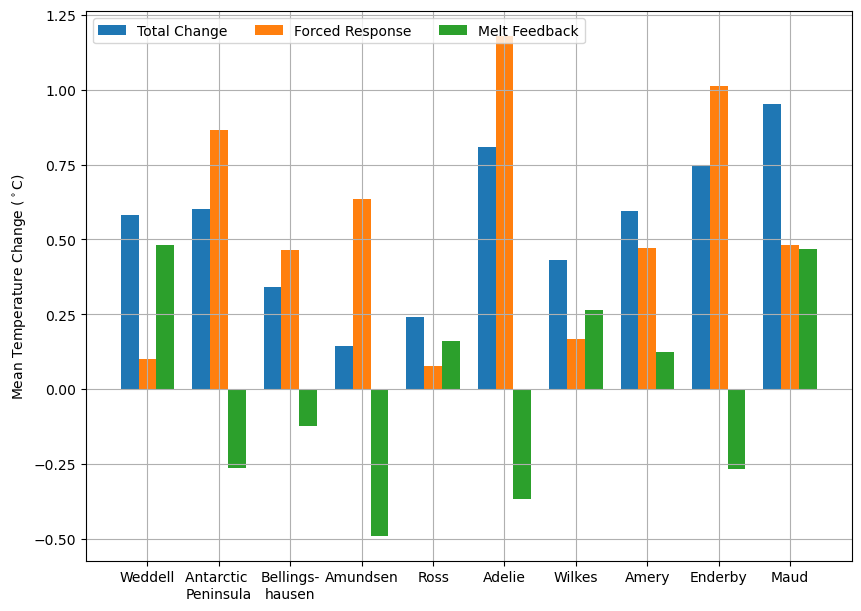

In [9]:
x = np.arange(len(species))  # the label locations\
width = 0.25  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(layout='constrained',figsize=(8.5,6))


for attribute, measurement in penguin_means.items():
    measurement = np.array(measurement)
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
#    ax.errorbar(x + offset, measurement, yerr=np.abs(measurement[:,1]), fmt="o", color="k")
#    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Temperature Change ($^\circ$C)')
ax.set_title('')
ax.grid()
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(-400, 600)


plt.show()





In [12]:
sqrtn = np.sqrt(120)
species = ( "Weddell", "Antarctic \nPeninsula","Bellings-\nhausen","Amundsen","Ross","Adelie",
           "Wilkes","Amery","Enderby","Maud")
penguin_means = {
    'Total Change': ( np.array(SSPSal) - np.array(PISal) ),
    'Forced Response': (  np.array(FixSal) - np.array(PISal) ),
    'Melt Feedback': (  np.array(SSPSal) - np.array(FixSal) ) , #:
    #( weddellMerr, apMerr, bellMerr, amundsenMerr, rossMerr, eaMerrE, 
                        #  eaMerrW,ameryMerr),
}


for attribute, measurement in penguin_means.items():
    print(np.array(measurement))
    print('next')
    
np.shape(measurement)


[-0.3544464  -0.2492981  -0.20728302 -0.22811508 -0.2633705  -0.11629486
 -0.12420273 -0.15478516 -0.26533508 -0.21548462]
next
[-0.06388855 -0.05547714 -0.00168228  0.02413177 -0.0272522  -0.05580902
 -0.02981186 -0.08299255 -0.14408112 -0.06422424]
next
[-0.29055786 -0.19382095 -0.20560074 -0.25224686 -0.23611832 -0.06048584
 -0.09439087 -0.0717926  -0.12125397 -0.15126038]
next


(10,)

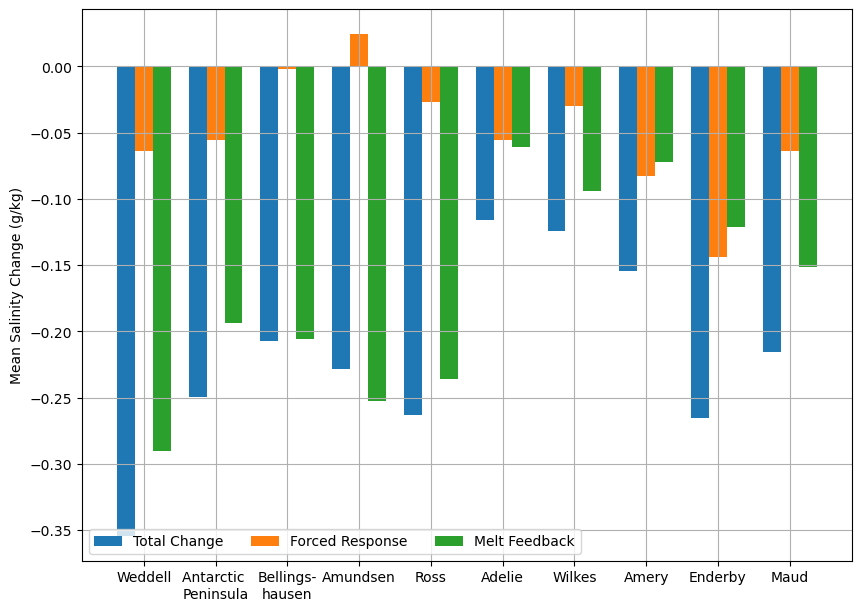

In [13]:
x = np.arange(len(species))  # the label locations\
width = 0.25  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(layout='constrained',figsize=(8.5,6))


for attribute, measurement in penguin_means.items():
    measurement = np.array(measurement)
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
#    ax.errorbar(x + offset, measurement, yerr=np.abs(measurement[:,1]), fmt="o", color="k")
#    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Salinity Change (g/kg)')
ax.set_title('')
ax.grid()
ax.set_xticks(x + width, species)
ax.legend(loc='lower left', ncols=3)
#ax.set_ylim(-400, 600)


plt.show()

<GeoAxes: >

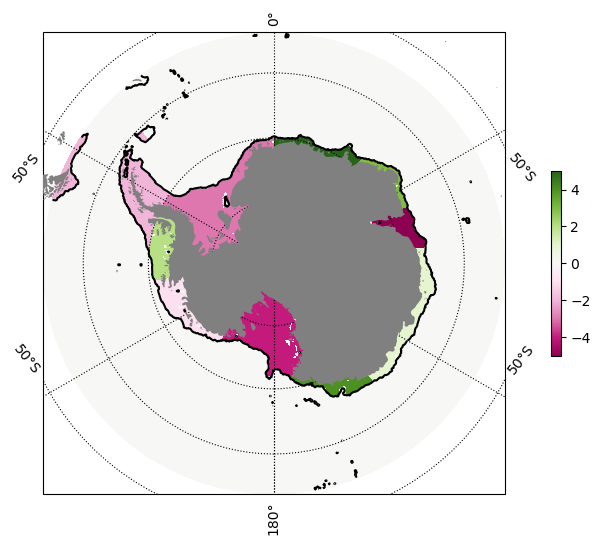

In [28]:
rosspI = xr.where((((coords.XC<=-145)|(coords.XC > 160))&(coords.YC<=-72))&(coords.Depth<800),-4,0)
adelie =  xr.where((((coords.XC > 140))&(coords.YC>-72))&(coords.Depth<800),4,0)

weddellpI = xr.where((((-65<coords.XC) & (coords.XC<=0) & (coords.YC<=-70))
                     |((-85<coords.XC) & (coords.XC<=0) & (coords.YC<=-74))) &(coords.Depth<800),-3,0)

amundsenpI = xr.where((((-145<coords.XC) & (coords.XC<=-98)) 
                     # | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<-72))
                      )&(coords.Depth<800),-1,0)
bellpI = xr.where((((-98<coords.XC)&(coords.XC<-65)&(coords.YC>-74) & (coords.YC<-70) )| 
                ((-98<coords.XC)&(coords.XC<=-85)&(coords.YC<-74)) 
                 )&(coords.Depth<800),2,0)
# | ((-103<coords.XC)&(coords.XC<=-100)&(coords.YC<=-72))
amerypI = xr.where(((coords.XC<=84) & (coords.XC>67))&(coords.Depth<800),-5,0)

enderby = xr.where(((40<coords.XC) & (coords.XC<=67) & (coords.Depth<800)),3,0)

eapIW = xr.where(((0<coords.XC) & (coords.XC<=40) & (coords.Depth<800)),5,0)

#((coords.XC>150)&(coords.YC>-70)))
eapIE = xr.where(((coords.XC>84) & (coords.XC<=140)) & (coords.Depth<800),1,0)

appI = xr.where(((-85<=coords.XC)&(coords.XC<-45)&(coords.YC>-70))&(coords.Depth<800),-2,0)

#mapper(eapIE,cmap='YlGnBu')

mapper(rosspI+weddellpI+appI+amundsenpI+amerypI+bellpI+eapIW+eapIE+enderby+adelie,cmap='PiYG')


In [62]:
#density calculations

temps = ds.temp.values
sals = ds.sal.values
deps = ds.z.values
%run dense_func.ipynb
rho = dens(ds.sal,ds.temp,p_ref).compute()
rho = rho-1000


# Define the min / max values for plotting isopycnals
# t_min = np.nanmin(temps) - 1
# t_max = np.nanmax(temps) + 1
# s_min = np.nanmin(sals) 
# s_max = np.nanmax(sals) + 1

t_min = -3
t_max = 1
s_min = 33.5
s_max = 35

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(np.ceil(s_max - s_min)/0.1)
ydim = int(np.ceil(t_max-t_min))
den = np.zeros((int(ydim),int(xdim)))

# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(0,ydim,ydim)+t_min
si = np.linspace(1,xdim,xdim)*0.1+s_min

# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        %run dense_func.ipynb
        den[j,i]=dens(si[i],ti[j],p_ref)

# Subtract 1000 to convert to sigma-t
den = den - 1000

plt.rcParams.update({'font.size': 20})
fig5 = plt.figure(figsize=(10,6))
CS = plt.contour(si,ti,den, linestyles='dashed', colors='k')
plt.clabel(CS, fontsize=12
           , inline=1
           , fmt='%.2f'
          ) # Label every second level


plt.scatter(sals,temps, 
             c=rho, cmap=plt.cm.viridis, 
             lw=0)
#plt.xlim([s_min + .5, s_max-.5])
plt.xlim([33.5, 35])
plt.ylim([t_min - .1, t_max + .1])
plt.xlabel('Salinity (g/kg)')
plt.ylabel(r'Potential Temperature $\theta$ ($\degree$C)')
plt.colorbar(label='Depth (m)',ticks=[0,-1000,-2000,-3000,-4000])
plt.tick_params(labelsize=15)
plt.title('All particles, all trajectories')
plt.show()


In [53]:
rosspI

<xarray.DataArray (j: 310, i: 1080)>
dask.array<where, shape=(310, 1080), dtype=int64, chunksize=(310, 1080), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309